<a href="https://colab.research.google.com/github/WeiKuoLi/LLM_bookclub/blob/main/%5Binference%5Dpaper_figure_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# LOAD FIGURE DETECTION MODEL


In [ ]:
from transformers import pipeline
import timm

thres=0.6
detector = pipeline(model="WKLI22/detr-resnet-50_finetuned_cppe5", use_safetensor=True, threshold=thres)

# x, y  are expressed relative to the top left hand corner.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

# DOWNLOAD FIGURE FROM CERTAIN URL

In [ ]:
# URL of the image
url = 'https://d13i5xhouzkrd.cloudfront.net/dc9c370b-040a-47fc-95d1-bbb1c76a0888/previews/output-9.png'
url = 'https://d13i5xhouzkrd.cloudfront.net/786e19c1-93bb-49bd-9ad9-8443e0d1b922/previews/output-4.png'
#url = 'https://0.academia-photos.com/attachment_thumbnails/105335235/mini_magick20230828-1-ypwtgr.png?1693219704'
#url ='https://pbs.twimg.com/media/Dr_SZchU4AAJHJn.jpg:large'
#url ='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTWJDx9_WWTvSZqBkPs4MBN_B1LMLFObvNwkg&usqp=CAU'
#print(detector(url))
#url ='https://images.deepai.org/publication-preview/3d-face-modeling-from-diverse-raw-scan-data-page-1-medium.jpg'
#url = 'https://digital.library.unt.edu/ark:/67531/metadc828907/m1/4/small_res/'

# INFERENCE PIPELINE & PLOT

Detected FIGURE with confidence 0.909 at location [66.99, 58.97, 781.27, 533.49]
tensor(0.9092) tensor(0) tensor([ 66.9861,  58.9684, 781.2700, 533.4889])


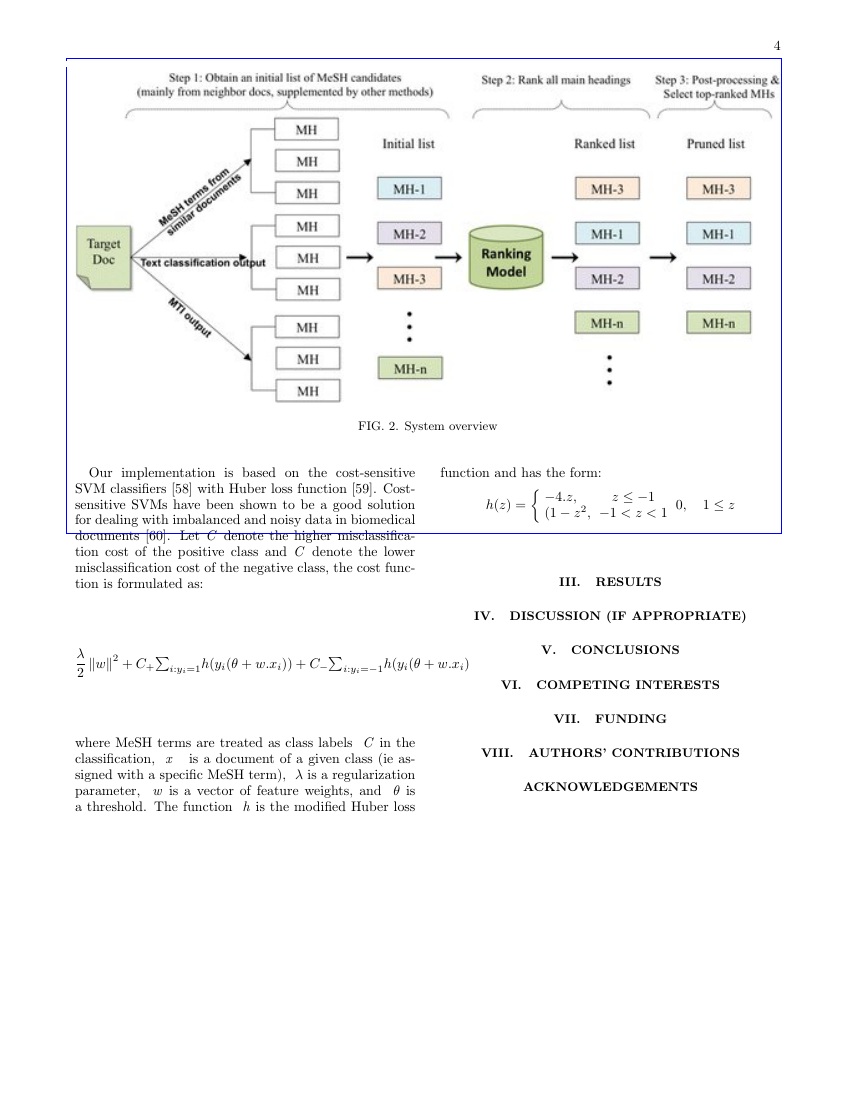

In [ ]:

from transformers import pipeline
import requests
from PIL import Image, ImageDraw
from io import BytesIO
import torch

# Download the image using requests
response = requests.get(url)

# Open the image using PIL
image = Image.open(BytesIO(response.content))

obj_detector = detector
model=detector.model
image_processor=detector.image_processor
# model="MariaK/detr-resnet-50_finetuned_cppe5")
#obj_detector(image)

from transformers import DetrImageProcessor, DetrForObjectDetection
#image_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
#model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
'''
model_dir = 'detr-resnet-50_finetuned_cppe5'
model.save_pretrained(model_dir)
image_processor.save_pretrained(model_dir)
image_processor = DetrImageProcessor.from_pretrained(model_dir)
model = DetrForObjectDetection.from_pretrained(model_dir)
'''
with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=thres, target_sizes=target_sizes)[0]
    #print(results)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(score, label, box)
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)

    draw.rectangle((x, y, x2, y2), outline="blue", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image